In [1]:
import numpy as np
import pandas as pd
import sklearn_evaluation
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import SelectPercentile
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.svm import LinearSVC, SVC


In [2]:
X = pd.read_csv("../dataset/extracted_features.csv").values
index_for_removal = np.array(
    [
        0, 10, 14, 17, 25, 26, 35, 39, 49, 59, 62,
    ]
)
X_indexed = np.delete(X, index_for_removal, 1)

y = pd.read_csv("../dataset/labels.csv").values
# images = pd.read_csv("../dataset/raw_images.csv").values
X_train, X_test, y_train, y_test = train_test_split(X_indexed, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)
y_train = y_train.ravel()

select = SelectPercentile(percentile=90)
select.fit(X_train, y_train)
X_train = select.transform(X_train)
X_test = select.transform(X_test)

scaler_standard = StandardScaler().fit(X_train)
X_train_standard = scaler_standard.transform(X_train)
X_test_standard = scaler_standard.transform(X_test)

scaler_robust = RobustScaler().fit(X_train)
X_train_robust = scaler_robust.transform(X_train)
X_test_robust = scaler_robust.transform(X_test)

scaler_minmax = MinMaxScaler().fit(X_train)
X_train_minmax = scaler_minmax.transform(X_train)
X_test_minmax = scaler_minmax.transform(X_test)

pca = PCA(n_components=40, random_state=42)
X_train_pca = pca.fit_transform(X_train_standard)
X_test_pca = pca.transform(X_test_standard)


In [3]:
np.random.seed(42)


def grid_search_random_forest(n_estimators, max_features, X_train_data, max_depth=None, max_leaf_nodes=None):
    parameters = {
        'n_estimators': n_estimators,
        'max_features': max_features,
    }
    include_additional_parameters(max_depth, max_leaf_nodes, parameters)

    classifier = RandomForestClassifier(random_state=42)

    grid_search = GridSearchCV(
        classifier,
        parameters,
        cv=4,
        return_train_score=True,
    )

    grid_search.fit(X_train_data, y_train)
    print_grid_search_results(grid_search, parameters)
    return grid_search


def print_grid_search_results(grid_search, parameters):
    for parameter in parameters:
        print(f'Best {parameter}:', grid_search.best_params_[parameter])
    predictions = grid_search.predict(X_test)
    print("Accuracy: ", metrics.accuracy_score(y_test, predictions))


def include_additional_parameters(max_depth, max_leaf_nodes, parameters):
    if max_depth is not None:
        parameters.update({'max_depth': max_depth})
    if max_leaf_nodes is not None:
        parameters.update({'max_leaf_nodes': max_leaf_nodes})


def graph_grid_search_random_forest(grid_search):
    print(grid_search.cv_results_)
    plt.figure(figsize=[8,8])
    sklearn_evaluation.evaluator.plot.grid_search(
        grid_search.cv_results_,
        change=("n_estimators", "max_features")
    )

    plt.title("Random Forest")
    plt.xlabel("n_estimators")
    plt.ylabel("max_features")
    plt.legend()
    plt.show()


def plot_3d_heatmap(grid_results):
    result_params = grid_results.cv_results_['params']
    df = pd.DataFrame(result_params)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x = df.loc[:, 'n_estimators']
    y = df.loc[:, 'max_features']
    z = df.loc[:, 'max_depth']
    c = grid_results.cv_results_['mean_test_score']
    img = ax.scatter(x, y, z, c=c, cmap=plt.hot())
    fig.colorbar(img)
    plt.show()

In [4]:
np.random.seed(42)

n_estimators = np.linspace(20, 40, 3, dtype=int)
max_features = np.linspace(1, 12, 6, dtype=int)

grid_search = grid_search_random_forest(n_estimators, max_features, X_train)

Best n_estimators: 40
Best max_features: 5
Accuracy:  0.8648648648648649


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


{'mean_fit_time': array([0.03796995, 0.0713324 , 0.07435244, 0.04429817, 0.06498426,
       0.1016385 , 0.05917716, 0.0758422 , 0.09626007, 0.06134552,
       0.08464617, 0.11332786, 0.06524342, 0.09079576, 0.12704039,
       0.07793444, 0.11436999, 0.15066725]), 'std_fit_time': array([0.00077356, 0.01524846, 0.00159505, 0.00084028, 0.00208599,
       0.01633757, 0.00555216, 0.00089834, 0.00091495, 0.00316103,
       0.00155314, 0.0021619 , 0.00049076, 0.00122931, 0.00543564,
       0.00223796, 0.00202086, 0.00356889]), 'mean_score_time': array([0.00379282, 0.00802749, 0.00676489, 0.00364637, 0.00507057,
       0.00807828, 0.0042395 , 0.00562328, 0.00602943, 0.00347793,
       0.00449777, 0.00577015, 0.00310713, 0.00497258, 0.00557452,
       0.00332552, 0.00484216, 0.00572073]), 'std_score_time': array([0.0002066 , 0.00240645, 0.00016921, 0.00029902, 0.00021665,
       0.00180455, 0.0009283 , 0.00073933, 0.00056325, 0.00048707,
       0.00011432, 0.00033688, 0.0004043 , 0.00048184, 0.

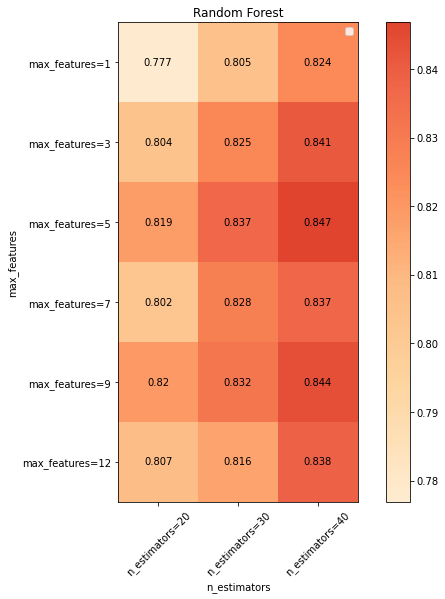

In [5]:

graph_grid_search_random_forest(grid_search)

In [8]:
np.random.seed(42)

n_estimators = np.linspace(30, 100, 3, dtype=int)
max_features = np.linspace(3, 16, 6, dtype=int)

grid_search_t2 = grid_search_random_forest(n_estimators, max_features, X_train)

Best n_estimators: 100
Best max_features: 3
Accuracy:  0.8581081081081081


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


{'mean_fit_time': array([0.06055748, 0.14654946, 0.18804193, 0.0628078 , 0.13828421,
       0.20972067, 0.08067131, 0.16210324, 0.24966496, 0.08707929,
       0.18384796, 0.27751732, 0.09280497, 0.21048427, 0.32091427,
       0.10647017, 0.23119074, 0.36182684]), 'std_fit_time': array([0.00317391, 0.03162527, 0.00699937, 0.00127062, 0.00428157,
       0.00151314, 0.00230547, 0.0009734 , 0.00469132, 0.00408342,
       0.00362789, 0.00219144, 0.00081921, 0.00390728, 0.00482571,
       0.00232869, 0.00279473, 0.00377933]), 'mean_score_time': array([0.00495529, 0.01113856, 0.01305455, 0.00493979, 0.0093326 ,
       0.01385677, 0.00466543, 0.0098145 , 0.01374769, 0.00433725,
       0.00935847, 0.01435274, 0.00488156, 0.00835854, 0.01253247,
       0.00434679, 0.00834852, 0.01293433]), 'std_score_time': array([0.00042789, 0.00201633, 0.00018292, 0.00050118, 0.00074098,
       0.00061587, 0.00085877, 0.00122533, 0.0010847 , 0.00033784,
       0.00082918, 0.00121137, 0.00047561, 0.00019134, 0.

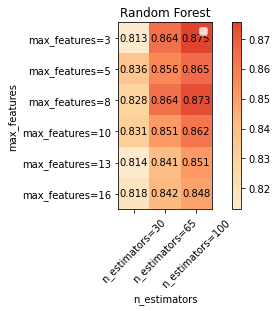

In [9]:

graph_grid_search_random_forest(grid_search_t2)


In [6]:
np.random.seed(42)

n_estimators = np.linspace(100, 600, 6, dtype=int)
max_features = np.linspace(1, 10, 10, dtype=int)

grid_search_t3 = grid_search_random_forest(n_estimators, max_features, X_train)

Best n_estimators: 200
Best max_features: 3
Accuracy:  0.8851351351351351


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


{'mean_fit_time': array([0.19582123, 0.33844835, 0.52100241, 0.67975444, 0.83265251,
       1.06195158, 0.19295621, 0.39399022, 0.60193324, 0.77871221,
       0.95164746, 1.16585875, 0.21230781, 0.42682946, 0.65319705,
       0.87950629, 1.03983963, 1.26211566, 0.23367208, 0.46834046,
       0.69278675, 0.89893538, 1.16969049, 1.41492546, 0.25905794,
       0.50358361, 0.73818952, 1.01600897, 1.30116457, 1.40419227,
       0.24375927, 0.48283881, 0.77236336, 0.99729961, 1.27492201,
       1.50258183, 0.2747075 , 0.54947919, 0.77016681, 1.04789245,
       1.28647602, 1.53943133, 0.27853501, 0.56119692, 0.81275135,
       1.08472222, 1.36418617, 1.66345483, 0.29238135, 0.58249938,
       0.89847904, 1.23225319, 1.62803155, 1.86363852, 0.33063245,
       0.66185582, 1.00023001, 1.35205173, 1.75325799, 2.07036167]), 'std_fit_time': array([0.02250676, 0.01214753, 0.0258554 , 0.01969701, 0.01266743,
       0.07258922, 0.0051516 , 0.0142886 , 0.01691795, 0.02576536,
       0.012766  , 0.01274

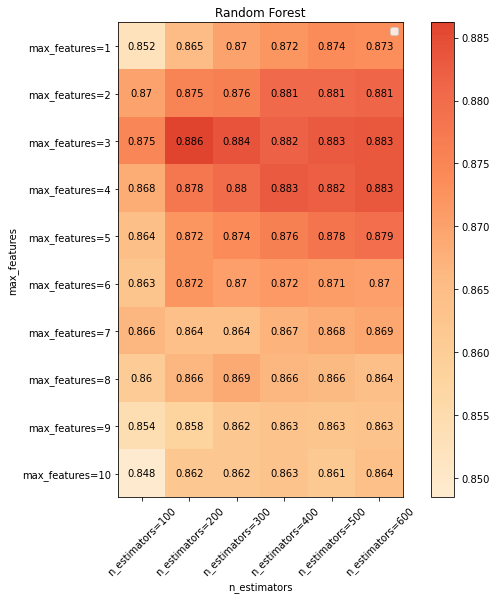

In [7]:

graph_grid_search_random_forest(grid_search_t3)

In [18]:
rf = RandomForestClassifier(max_features=5, n_estimators=500).fit(X_train, y_train)
y_predictions = rf.predict(X_test)
print("Train: ", rf.score(X_train, y_train))
print("Test: ", rf.score(X_test, y_test))

Train:  0.9915492957746479
Test:  0.8918918918918919


standard

In [5]:

np.random.seed(42)

n_estimators = np.linspace(100, 600, 6, dtype=int)
max_features = np.linspace(1, 10, 10, dtype=int)

grid_search_standard = grid_search_random_forest(n_estimators, max_features, X_train_standard)


Best n_estimators: 500
Best max_features: 5
Accuracy:  0.3783783783783784


In [6]:
rf_standard = RandomForestClassifier(
    n_estimators=grid_search_standard.best_params_['n_estimators'],
    max_features=grid_search_standard.best_params_['max_features'],
).fit(X_train_standard, y_train)
print(rf_standard.score(X_train_standard, y_train))
print(rf_standard.score(X_test_standard, y_test))

0.9915492957746479
0.8918918918918919


robust

In [7]:

np.random.seed(42)

n_estimators = np.linspace(100, 600, 6, dtype=int)
max_features = np.linspace(1, 10, 10, dtype=int)

grid_search_robust = grid_search_random_forest(n_estimators, max_features, X_train_robust)

Best n_estimators: 500
Best max_features: 5
Accuracy:  0.6148648648648649


In [8]:


rf_robust = RandomForestClassifier(
    n_estimators=grid_search_robust.best_params_['n_estimators'],
    max_features=grid_search_robust.best_params_['max_features'],
).fit(X_train_robust, y_train)
print(rf_robust.score(X_train_robust, y_train))
print(rf_robust.score(X_test_robust, y_test))

0.9915492957746479
0.8918918918918919


minmax

In [9]:

np.random.seed(42)

n_estimators = np.linspace(100, 600, 6, dtype=int)
max_features = np.linspace(1, 10, 10, dtype=int)

grid_search_minmax = grid_search_random_forest(n_estimators, max_features, X_train_minmax)


Best n_estimators: 500
Best max_features: 5
Accuracy:  0.5968468468468469


In [10]:

rf_minmax = RandomForestClassifier(
    n_estimators=grid_search_minmax.best_params_['n_estimators'],
    max_features=grid_search_minmax.best_params_['max_features'],
).fit(X_train_minmax, y_train)
print(rf_minmax.score(X_train_minmax, y_train))
print(rf_minmax.score(X_test_minmax, y_test))


0.9915492957746479
0.8918918918918919


pca

In [11]:

np.random.seed(42)

n_estimators = np.linspace(100, 600, 6, dtype=int)
max_features = np.linspace(1, 10, 10, dtype=int)

grid_search_pca = grid_search_random_forest(n_estimators, max_features, X_train_pca)


Best n_estimators: 600
Best max_features: 3


ValueError: X has 64 features, but RandomForestClassifier is expecting 56 features as input.

In [14]:

rf_pca = RandomForestClassifier(
    n_estimators=600,
    max_features=3,
).fit(X_train_pca, y_train)
print(rf_pca.score(X_train_pca, y_train))
print(rf_pca.score(X_test_pca, y_test))

0.9915492957746479
0.8738738738738738
